In [1]:
import pickle
import itertools

import numpy as np
import pandas as pd
# %config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from collections import defaultdict

In [2]:
with open('../input/quantile/human_weight_rf_data_filtered_qdelta_data.pickle', 'rb') as fh:
    x, y, tf_list = pickle.load(fh)

FileNotFoundError: [Errno 2] No such file or directory: '../input/quantile/human_weight_rf_data_filtered_qdelta_data.pickle'

In [ ]:
idx = tf_list.index('PLAG1')
sns.distplot(y['PSI'][x[:, idx]])
sns.distplot(y['PSI'][~x[:, idx]])
print(x[:, idx].sum())
print(x.shape[0] - x[:, idx].sum())
plt.show()

In [21]:
gene_list = y.groupby('Gene')
filtered_y = gene_list.filter(lambda x: len(x) > 2)[['Gene', 'PSI']]
gene_list = filtered_y.groupby('Gene')

In [23]:
psi_mean = gene_list.mean()
sorted_gene_order = list(psi_mean.sort_values(by='PSI').index)
psi_stdev = gene_list.std()

In [24]:
gene_list.count()

,PSI
Gene,
ENSG00000000419,15
ENSG00000000457,14
ENSG00000001167,66
ENSG00000001460,29
ENSG00000001497,38
ENSG00000001617,10
ENSG00000001631,101
ENSG00000002016,6
ENSG00000002822,28


In [7]:
filtered_y.Gene = filtered_y.Gene.astype("category")
filtered_y.Gene.cat.set_categories(sorted_gene_order, inplace=True)
filtered_y = filtered_y.sort_values("Gene").dropna().reset_index()

In [27]:
y.Gene = y.Gene.astype("category")
y.Gene.cat.set_categories(sorted_gene_order, inplace=True)
filtered_y = y.sort_values("Gene").dropna().reset_index()

## Machine Learning

In [2]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

In [3]:
with open('../input/quantile/weight_quantile_rf_delta_data.pickle', 'rb') as fh:
    x, y, tf_list = pickle.load(fh)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=9487)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.125, random_state=9487)

In [5]:
true_idx = y_train[y_train['psi_group'] == True].index
false_idx = y_train[y_train['psi_group'] == False].index

In [15]:
true_idx.size

78426

In [12]:
np.random.seed(seed=9487)
true_idx = np.random.choice(true_idx, size=len(false_idx), replace=True)
selected_idx = np.concatenate([true_idx, false_idx])
selected_idx.sort()

In [12]:
x_train = x[selected_idx]
y_train = np.asarray(y.loc[selected_idx, 'psi_group'], dtype='bool')

In [13]:
y_test = np.asarray(y_test['psi_group'], dtype='bool')
y_val = np.asarray(y_val['psi_group'], dtype='bool')

In [14]:
true_idx = y[y['psi_group'] == True].index
false_idx = y[y['psi_group'] == False].index

In [30]:
# false_idx = np.random.choice(false_idx, size=len(true_idx), replace=False)
true_idx = np.random.choice(true_idx, size=len(false_idx), replace=True)
selected_idx = np.concatenate([true_idx, false_idx])
selected_idx.sort()

In [31]:
x_data = x[selected_idx]
y_data = np.asarray(y.loc[selected_idx, 'psi_group'], dtype='bool')

In [30]:
ks_test_result = pd.read_csv('../output/ks_test_weight_zpsi_delta/ks_test.csv', index_col=0)
top_tf = ks_test_result.sort_values('pvalue').iloc[:50].index.tolist()

In [31]:
tf_list = np.array(tf_list)
top_tf_idx = np.where(np.isin(tf_list, top_tf))[0]

In [33]:
idx = np.random.choice(y.index[~y['label']], size=y['label'].sum(), replace=False)
idx = np.concatenate([idx, y.index[y['label']]])

In [34]:
x_data = x[idx.reshape((idx.shape[0], 1)), top_tf_idx]
y_data = np.array(y.loc[idx, 'label'])

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=9487)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.125, random_state=9487)

NameError: name 'x_data' is not defined

In [15]:
# clf = ExtraTreesClassifier(n_estimators=200,
#                            min_impurity_decrease=1e-5,
#                            n_jobs = 12,
#                            random_state=9487)
param_dist = {'booster': 'gbtree',
              'eta': 0.1,
              'n_estimators': 2000,
              'max_depth': 6,
              'colsample_bytree': 0.5,
              'objective': 'binary:logistic',
              'tree_method': 'gpu_exact'}
clf = XGBClassifier(**param_dist)

In [16]:
clf = clf.fit(x_train, y_train,
              eval_set=[(x_val, y_val)],
              eval_metric='logloss',
              early_stopping_rounds=5,
              verbose=True)

[0]	validation_0-logloss:0.681441
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.671942
[2]	validation_0-logloss:0.663972
[3]	validation_0-logloss:0.657266
[4]	validation_0-logloss:0.651657
[5]	validation_0-logloss:0.646886
[6]	validation_0-logloss:0.642357
[7]	validation_0-logloss:0.638621
[8]	validation_0-logloss:0.635451
[9]	validation_0-logloss:0.632679
[10]	validation_0-logloss:0.63011
[11]	validation_0-logloss:0.627852
[12]	validation_0-logloss:0.626029
[13]	validation_0-logloss:0.6245
[14]	validation_0-logloss:0.623114
[15]	validation_0-logloss:0.621664
[16]	validation_0-logloss:0.620458
[17]	validation_0-logloss:0.618632
[18]	validation_0-logloss:0.617724
[19]	validation_0-logloss:0.616019
[20]	validation_0-logloss:0.614494
[21]	validation_0-logloss:0.613222
[22]	validation_0-logloss:0.612627
[23]	validation_0-logloss:0.611889
[24]	validation_0-logloss:0.611098
[25]	validation_0-logloss:0.610528
[26]	validation_0-logloss:0.609959
[

In [17]:
accuracy_score(y_train, clf.predict(x_train))

0.8656822992374977

In [18]:
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.739635548740933

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.81458558 0.18541442]
 [0.40420038 0.59579962]]


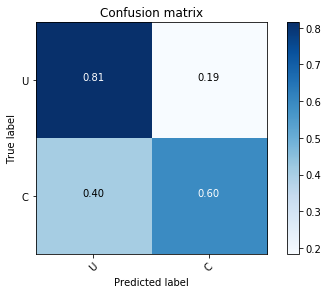

In [20]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['U', 'C'], normalize=True)
plt.show()

## T-SNE

In [16]:
from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

In [23]:
def plot_tsne(x_embedded, y_data, output_file=False):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_embedded[:, 0], x_embedded[:, 1], s=1,
               marker='o', c=y_data, cmap='seismic')
    if output_file:
        fig.savefig('tsne_tf_feature.png', dpi=300)

In [24]:
def inspect_feature(x_data, y_data, use_pca=False, pca_comp=100, random_state=None):
    np.random.seed(random_state)
    rand_idx = np.random.randint(0, len(x_data), size=round(len(x_data) * 0.1))
    x_data_sub = x_data[rand_idx]
    y_data_sub = y_data[rand_idx]
    print((x_data_sub.shape, y_data_sub.shape))
    if use_pca:
        x_data_sub = PCA(n_components=pca_comp,
                         random_state=random_state).fit_transform(x_data_sub)

    x_embedded = TSNE(n_components=2,
                      perplexity=50.0,
                      n_jobs=15,
                      random_state=random_state).fit_transform(x_data_sub)

    plot_tsne(x_embedded, y_data_sub, output_file=False)

In [1]:
X = np.random.random((100000, 50))
TSNE(verbose=1).fit_transform(X)

NameError: name 'np' is not defined

In [25]:
inspect_feature(x_data, y_data, use_pca=True, pca_comp=20)

((13247, 50), (13247,))
